In [1]:
# Imports and Setup
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")
print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Data Loading
df = pd.read_csv('../data/stock_data.csv')
df['Date'] = pd.to_datetime(df['Date'])
print("Dataset loaded successfully.")
print(f"Shape of the dataset: {df.shape}")
print("\nFirst 5 rows:")
display(df.head())

Dataset loaded successfully.
Shape of the dataset: (25200, 7)

First 5 rows:


,Date,Ticker,Open,High,Low,Close,Volume
0,2020-10-26,STCKA,498.38,503.33,498.35,501.11,1779902
1,2020-10-27,STCKA,501.54,505.12,498.43,502.85,2274264
2,2020-10-28,STCKA,507.89,510.28,501.89,502.82,1721465
3,2020-10-29,STCKA,502.44,502.56,498.83,501.70,4343654
4,2020-10-30,STCKA,498.51,504.25,494.78,500.35,3403035


In [3]:
# Data Processing and Feature Engineering
def create_features(df):
    """
    Creates time-series features from a dataframe.
    """
    df_featured = df.copy()
    # Target variable: what we want to predict (e.g., tomorrow's close price)
    df_featured['target'] = df_featured['Close'].shift(-1)
    # Lag features (price from previous days)
    for i in range(1, 6):
        df_featured[f'lag_{i}'] = df_featured['Close'].shift(i)
        
    # Moving averages
    df_featured['ma_5'] = df_featured['Close'].rolling(window=5).mean()
    df_featured['ma_20'] = df_featured['Close'].rolling(window=20).mean()
    # Volatility
    df_featured['volatility'] = df_featured['Close'].rolling(window=5).std()
    # Drop rows with NaN values created by shifts and rolling windows
    df_featured = df_featured.dropna()
    return df_featured

# Process one stock to visualize features
sample_ticker = 'STCKA'
df_sample = df[df['Ticker'] == sample_ticker].sort_values('Date')
df_featured_sample = create_features(df_sample)
print(f"Features created for {sample_ticker}. New shape: {df_featured_sample.shape}")
print("\nFirst 5 rows with new features:")
display(df_featured_sample.head())

Features created for STCKA. New shape: (1240, 16)

First 5 rows with new features:


,Date,Ticker,Open,High,Low,Close,Volume,target,lag_1,lag_2,lag_3,lag_4,lag_5,ma_5,ma_20,volatility
19,2020-11-20,STCKA,507.47,509.36,504.95,507.48,1628597,499.90,517.96,514.07,508.61,520.60,512.40,513.744,510.7165,5.711421
20,2020-11-23,STCKA,497.09,504.40,493.20,499.90,3811745,515.71,507.48,517.96,514.07,508.61,520.60,509.604,510.6560,6.881768
21,2020-11-24,STCKA,520.28,523.46,514.04,515.71,4075618,517.36,499.90,507.48,517.96,514.07,508.61,511.024,511.2990,7.342481
22,2020-11-25,STCKA,515.95,521.34,511.11,517.36,2768479,518.19,515.71,499.90,507.48,517.96,514.07,511.682,512.0260,7.815851
23,2020-11-26,STCKA,517.20,521.00,512.25,518.19,1539068,523.07,517.36,515.71,499.90,507.48,517.96,511.728,512.8505,7.862574


In [4]:
# Model Training and Evaluation Pipeline
def train_and_evaluate(df_ticker):
    """
    Trains and evaluates Linear Regression and Random Forest models for a single stock ticker.
    """
    if df_ticker.empty or len(df_ticker) < 50: # Ensure enough data
        return None

    # 1. Feature Engineering
    df_featured = create_features(df_ticker)
    
    # 2. Define Features (X) and Target (y)
    features = [col for col in df_featured.columns if col not in ['Date', 'Ticker', 'target']]
    X = df_featured[features]
    y = df_featured['target']

    # 3. Time-Series Split (train on past, test on recent)
    tscv = TimeSeriesSplit(n_splits=5)
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # 4. Initialize Models
    lr_model = LinearRegression()
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

    # 5. Train Models
    lr_model.fit(X_train, y_train)
    rf_model.fit(X_train, y_train)

    # 6. Make Predictions
    lr_preds = lr_model.predict(X_test)
    rf_preds = rf_model.predict(X_test)

    # 7. Evaluate Performance
    lr_mse = mean_squared_error(y_test, lr_preds)
    rf_mse = mean_squared_error(y_test, rf_preds)
    
    # 8. Forecast the next day's price
    last_features = X.iloc[[-1]] # Get the very last row of features
    lr_forecast = lr_model.predict(last_features)[0]
    rf_forecast = rf_model.predict(last_features)[0]

    # Return results
    return {
        'ticker': df_ticker['Ticker'].iloc[0],
        'last_close': df_ticker['Close'].iloc[-1],
        'lr_mse': lr_mse,
        'rf_mse': rf_mse,
        'lr_forecast': lr_forecast,
        'rf_forecast': rf_forecast,
        'best_model': 'Random Forest' if rf_mse < lr_mse else 'Linear Regression'
    }

print("Model training pipeline is ready.")

Model training pipeline is ready.


In [5]:
# Running the Pipeline for All Stocks
tickers = df['Ticker'].unique()
all_results = []
for ticker in tickers:
    print(f"Processing {ticker}...")
    df_ticker = df[df['Ticker'] == ticker].sort_values('Date')
    result = train_and_evaluate(df_ticker)
    if result:
        all_results.append(result)

results_df = pd.DataFrame(all_results)
print("\nProcessing complete. Model evaluation results:")
display(results_df)

Processing STCKA...
Processing STCKB...
Processing STCKC...
Processing STCKD...
Processing STCKE...
Processing STCKF...
Processing STCKG...
Processing STCKH...
Processing STCKI...
Processing STCKJ...
Processing STCKK...
Processing STCKL...
Processing STCKM...
Processing STCKN...
Processing STCKO...
Processing STCKP...
Processing STCKQ...
Processing STCKR...
Processing STCKS...
Processing STCKT...

Processing complete. Model evaluation results:


,ticker,last_close,lr_mse,rf_mse,lr_forecast,rf_forecast,best_model
0,STCKA,721.92,76.101819,78.351203,729.722679,727.1661,Linear Regression
1,STCKB,207.81,7.737766,26.355288,211.174360,206.3963,Linear Regression
2,STCKC,344.79,192.715875,4732.250408,342.240682,341.4887,Linear Regression
3,STCKD,353.08,41.280514,68.001340,358.901065,357.8480,Linear Regression
4,STCKE,347.34,92.319209,11048.041506,352.877898,292.9623,Linear Regression
5,STCKF,315.12,70.891352,75.524977,318.775591,322.6425,Linear Regression
6,STCKG,784.31,121.207612,218.681160,772.379548,775.6927,Linear Regression
7,STCKH,160.01,16.961864,18.962186,157.545280,156.9247,Linear Regression
8,STCKI,17.23,0.401866,190.188434,17.797040,32.4310,Linear Regression
9,STCKJ,191.10,23.760996,93.030430,194.074719,215.6984,Linear Regression


In [6]:
# Ranking and Final Results
# Calculate forecasted growth potential
def calculate_growth(row):
    forecast = row['rf_forecast'] if row['best_model'] == 'Random Forest' else row['lr_forecast']
    return ((forecast - row['last_close']) / row['last_close']) * 100
results_df['forecasted_growth_%'] = results_df.apply(calculate_growth, axis=1)
# Sort by the highest predicted growth
ranked_df = results_df.sort_values('forecasted_growth_%', ascending=False).reset_index(drop=True)
print("Final Ranked List of Stocks by Forecasted Growth Potential:")
display(ranked_df[['ticker', 'last_close', 'best_model', 'forecasted_growth_%']])

Final Ranked List of Stocks by Forecasted Growth Potential:


,ticker,last_close,best_model,forecasted_growth_%
0,STCKI,17.23,Linear Regression,3.291007
1,STCKN,36.76,Linear Regression,2.869597
2,STCKD,353.08,Linear Regression,1.648653
3,STCKB,207.81,Linear Regression,1.618959
4,STCKE,347.34,Linear Regression,1.594374
5,STCKJ,191.10,Linear Regression,1.556630
6,STCKT,42.17,Linear Regression,1.539762
7,STCKS,928.49,Linear Regression,1.209902
8,STCKF,315.12,Linear Regression,1.160063
9,STCKA,721.92,Linear Regression,1.080823


/tmp/ipykernel_3145/3455490155.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='forecasted_growth_%', y='ticker', data=ranked_df, palette='viridis')


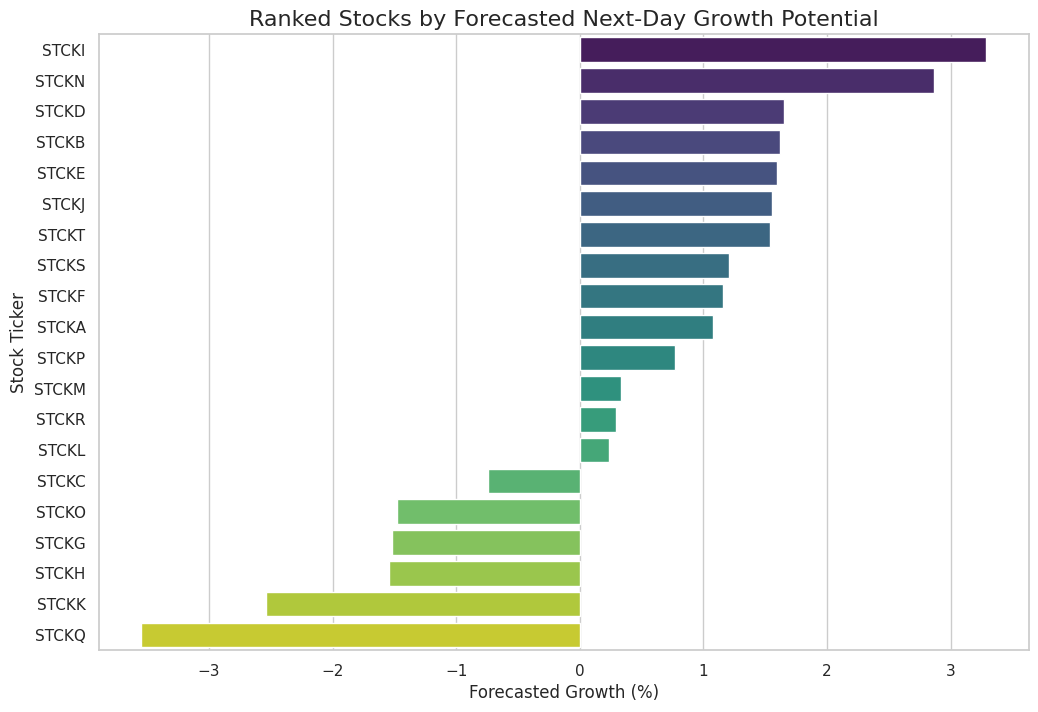

In [7]:
# CELL 7: Visualization of Results
plt.figure(figsize=(12, 8))
sns.barplot(x='forecasted_growth_%', y='ticker', data=ranked_df, palette='viridis')
plt.title('Ranked Stocks by Forecasted Next-Day Growth Potential', fontsize=16)
plt.xlabel('Forecasted Growth (%)', fontsize=12)
plt.ylabel('Stock Ticker', fontsize=12)
plt.show()